In [31]:
import pandas as pd
import numpy as np
# from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [32]:
df_reg = pd.read_csv('data-p3/queuing-data-for-regression.csv')
df_reg

,cluster,avg_C0,avg_arrival_rate,est_service_rate,arrival_rate_per_server,service_rate_per_server
0,Weekday - 0:00 - 4:00,NaN,NaN,NaN,NaN,NaN
1,Weekday - 4:00 - 8:00,1.914130,0.730833,0.848,0.381810,0.443021
2,Weekday - 8:00 - 12:00,1.354882,1.063013,1.197,0.784580,0.883472
3,Weekday - 12:00 - 16:00,1.342838,1.052115,1.218,0.783501,0.907034
4,Weekday - 16:00 - 20:00,1.499324,1.090321,1.289,0.727208,0.859721
5,Weekday - 20:00 - 0:00,1.030981,0.074487,0.214,0.072249,0.207569
6,Weekend - 0:00 - 4:00,NaN,NaN,NaN,NaN,NaN
7,Weekend - 4:00 - 8:00,1.899761,0.711265,0.849,0.374397,0.446898
8,Weekend - 8:00 - 12:00,1.235468,0.886728,1.048,0.717727,0.848261
9,Weekend - 12:00 - 16:00,1.303743,1.076080,1.245,0.825378,0.954943


In [33]:
df_reg.dropna(inplace=True)

In [34]:
X = df_reg[['arrival_rate_per_server']]
y = df_reg['service_rate_per_server']

In [35]:
model = LinearRegression()

model.fit(X,y)

LinearRegression()

In [38]:
y_pred = model.predict(X)

slope = model.coef_[0]
intercept = model.intercept_

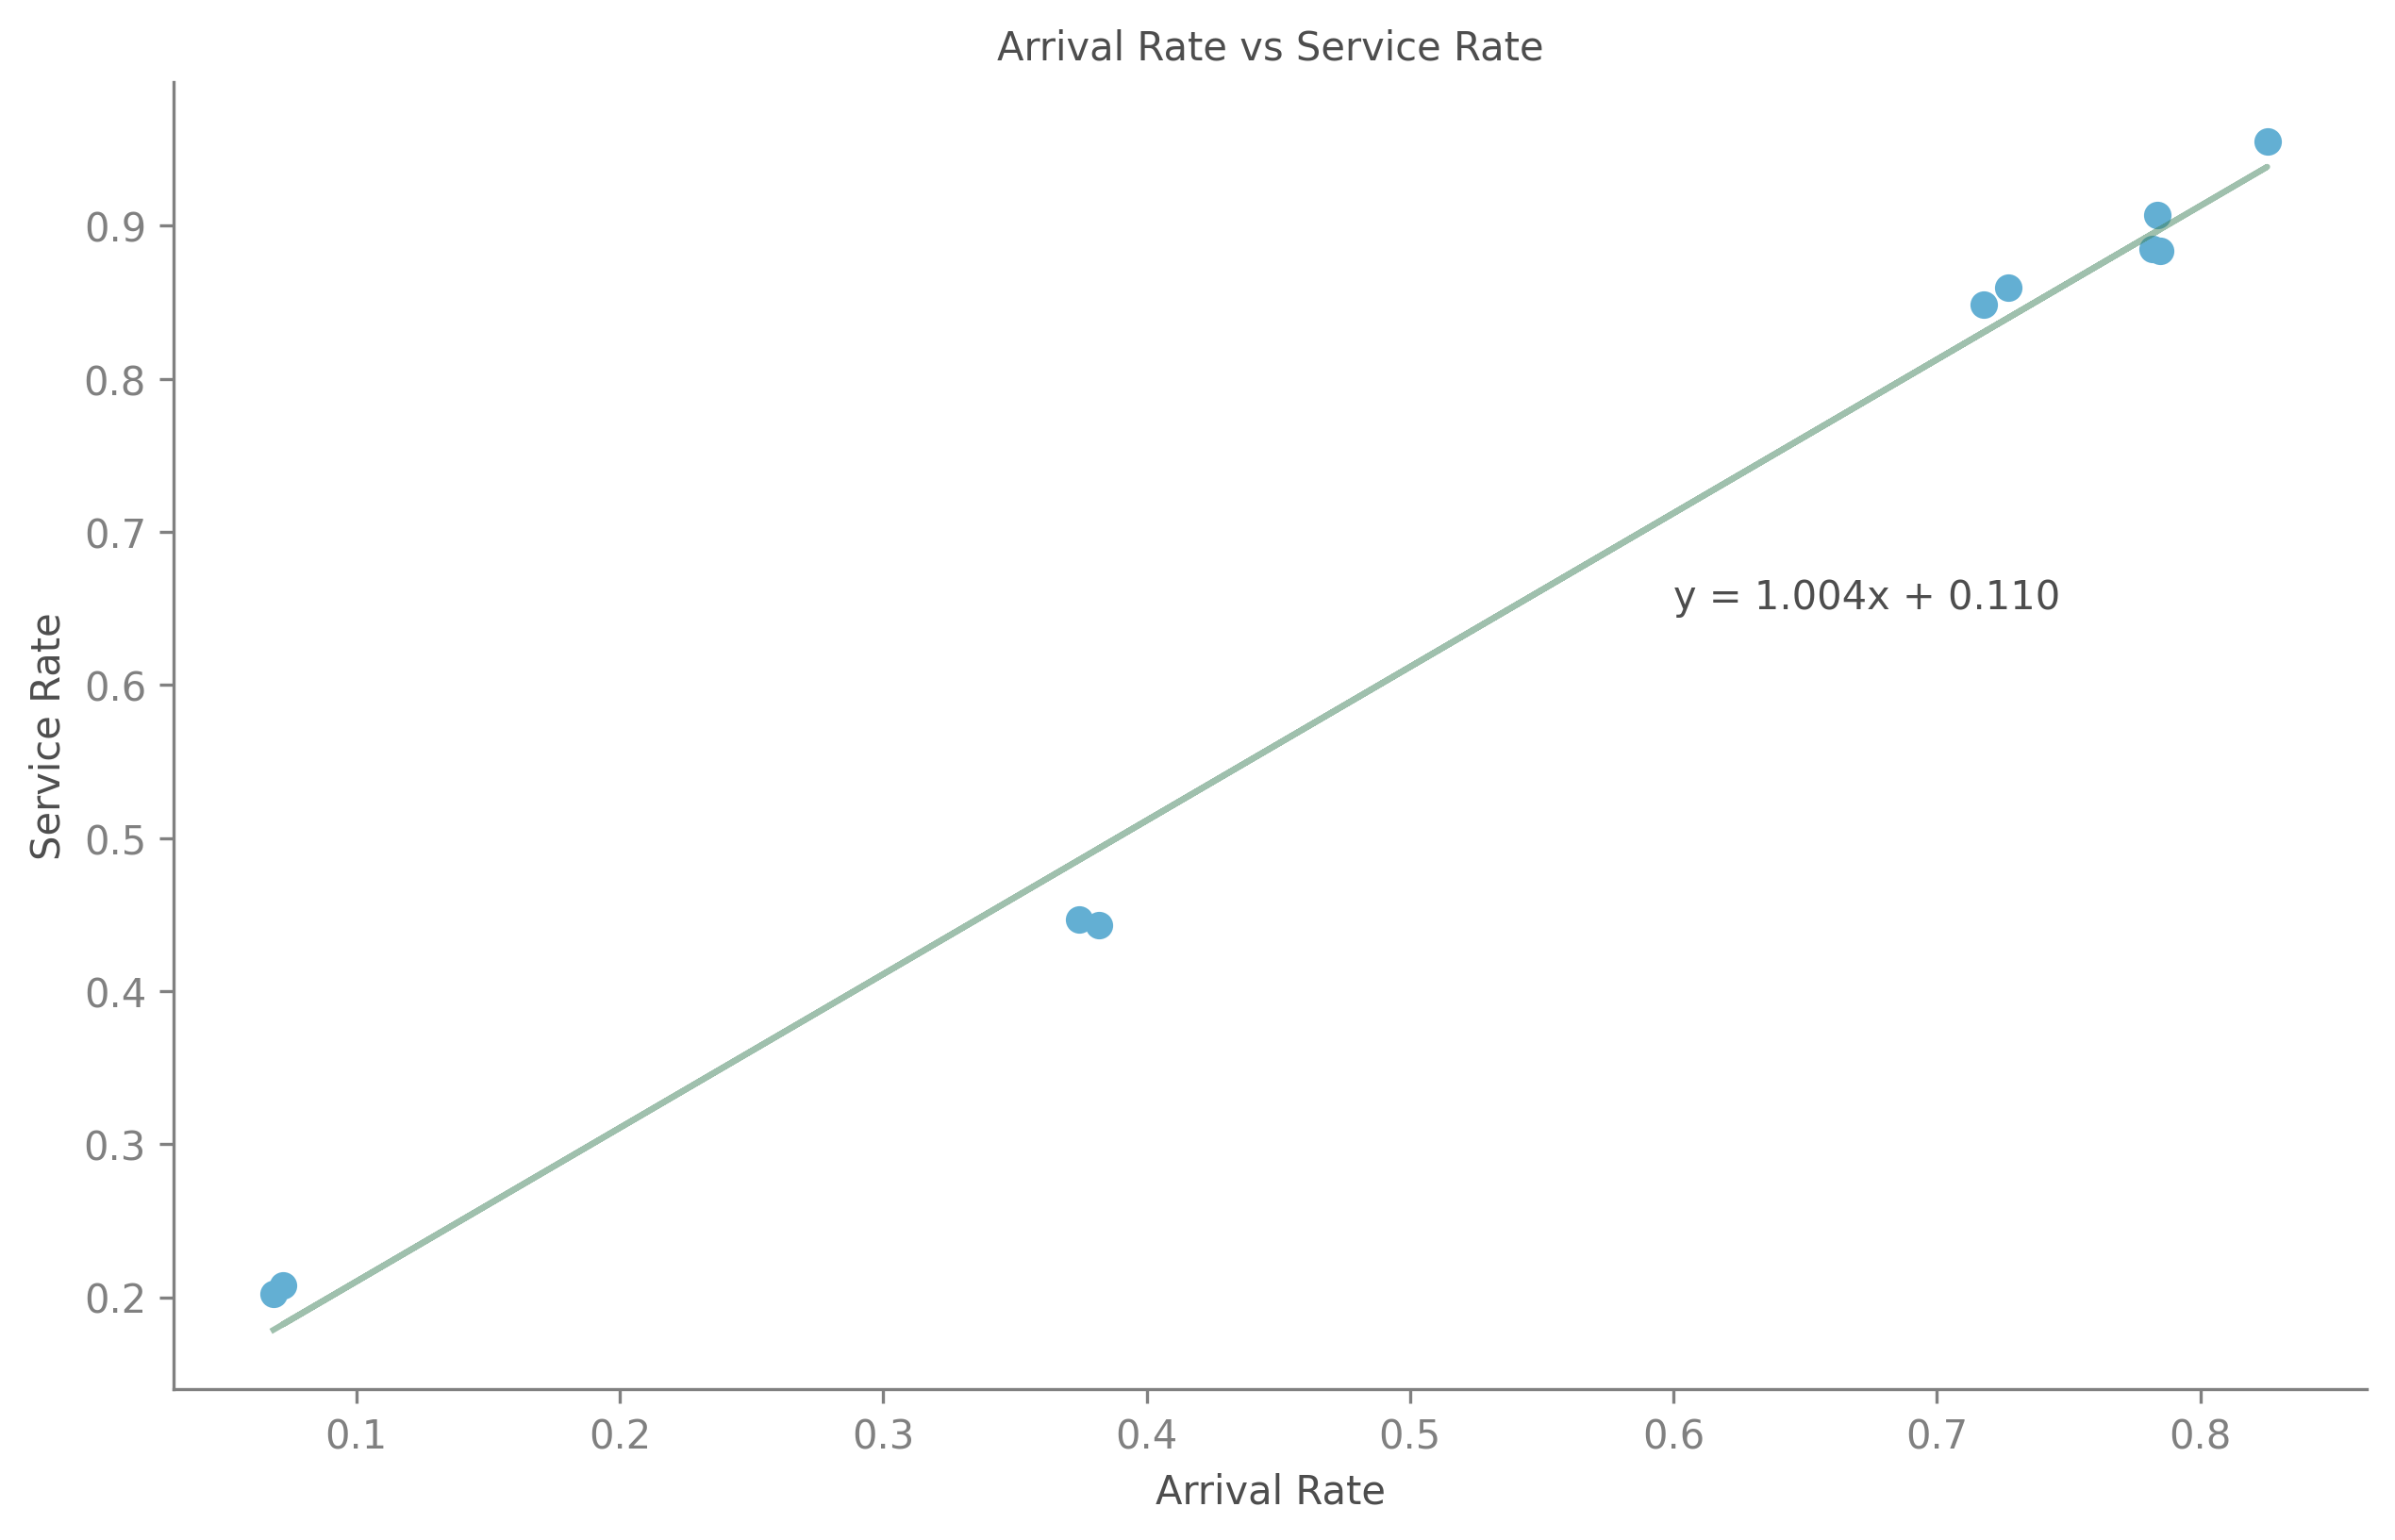

In [69]:
plt.figure(figsize=(10, 6), dpi=300)
plt.scatter(X, y, color='#63afd3',label='Actual Data')

# Plot the Regression Line

plt.plot(X, y_pred, color='#41825d', alpha = 0.5, label='Regression Line')

ax = plt.gca()  # Get the current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='both', which='both', colors='gray')

ax.set_xlabel('Arrival Rate', color='#4d4d4d')
ax.set_ylabel('Service Rate', color='#4d4d4d')
ax.set_title('Arrival Rate vs Service Rate', color='#4d4d4d', fontsize=10)

plt.text(x=0.6, y=0.65, s=equation, fontsize=10, color='#4d4d4d')  # Adjust x, y coordinates as needed



plt.savefig(f'website_figures/regression.png', format='png', bbox_inches='tight', transparent=False, dpi=600)

<Figure size 640x480 with 0 Axes>

In [7]:
df = pd.read_csv('data-p3/joined_all_clustered.csv')

In [8]:
cluster_ord = [
    "Weekday - 0:00 - 4:00", "Weekday - 4:00 - 8:00", "Weekday - 8:00 - 12:00", 
    "Weekday - 12:00 - 16:00", "Weekday - 16:00 - 20:00", "Weekday - 20:00 - 0:00",
    "Weekend - 0:00 - 4:00", "Weekend - 4:00 - 8:00", "Weekend - 8:00 - 12:00", 
    "Weekend - 12:00 - 16:00", "Weekend - 16:00 - 20:00", "Weekend - 20:00 - 0:00"
]

df['cluster'] = pd.Categorical(df['cluster'], categories=cluster_ord, ordered=True)
df = df.sort_values('cluster')

In [9]:
thresholds = [5, 10, 15, 20, 25, 30]

cluster_metrics = df.groupby('cluster').apply(
    lambda group: pd.Series({
        'arrival_rate': len(group) / (group['cluster_hours'].mean() * 60),
        'avg_wait': group['wait_time_imp'].mean(),
        'avg_C0': group['C0 - S2'].mean()
    })
).reset_index()

cluster_metrics['est_service_rate'] = intercept * cluster_metrics['avg_C0'] + slope * cluster_metrics['arrival_rate']

cluster_metrics['traffic_intensity'] = cluster_metrics['arrival_rate'] / cluster_metrics['est_service_rate']

qos_results = []
for _, row in cluster_metrics.iterrows():
    cluster = row['cluster']
    arrival_rate = row['arrival_rate']
    avg_C0 = row['avg_C0']
    clas = arrival_rate / avg_C0
    est_service_rate = intercept * avg_C0 + slope * arrival_rate
    
    qos_estimates = {}
    for x in thresholds:
        if arrival_rate < est_service_rate:  # Ensure λ < μ
            decay_factor = -(intercept * avg_C0 + slope * arrival_rate - arrival_rate) * x
            qos = 1 - (arrival_rate / est_service_rate) * np.exp(decay_factor)
            qos_estimates[f"<= {x} mins"] = f"{max(qos, 0):.1%}"
        else:
            qos_estimates[f"<= {x} mins"] = "N/A" 
    
    result = {
        "Cluster": cluster,
        "Class": round(clas, 1),
        "Est Serv Rate (per minute)": round(est_service_rate, 3),
        "Est ρ": round(arrival_rate / est_service_rate, 3),
        **qos_estimates
    }
    qos_results.append(result)

df_qos = pd.DataFrame(qos_results)
df_qos


/var/folders/8t/19klq0xd5w7cf39d3893ts0w0000gn/T/ipykernel_50119/2117464508.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_metrics = df.groupby('cluster').apply(
/var/folders/8t/19klq0xd5w7cf39d3893ts0w0000gn/T/ipykernel_50119/2117464508.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_metrics = df.groupby('cluster').apply(


,Cluster,Class,Est Serv Rate (per minute),Est ρ,<= 5 mins,<= 10 mins,<= 15 mins,<= 20 mins,<= 25 mins,<= 30 mins
0,Weekday - 0:00 - 4:00,NaN,NaN,NaN,N/A,N/A,N/A,N/A,N/A,N/A
1,Weekday - 4:00 - 8:00,0.4,0.935,0.782,71.8%,89.8%,96.3%,98.7%,99.5%,99.8%
2,Weekday - 8:00 - 12:00,0.8,1.211,0.878,58.1%,80.0%,90.4%,95.4%,97.8%,99.0%
3,Weekday - 12:00 - 16:00,0.8,1.196,0.880,57.2%,79.1%,89.8%,95.0%,97.6%,98.8%
4,Weekday - 16:00 - 20:00,0.8,1.252,0.871,61.3%,82.8%,92.4%,96.6%,98.5%,99.3%
5,Weekday - 20:00 - 0:00,0.1,0.188,0.396,77.5%,87.3%,92.8%,95.9%,97.7%,98.7%
6,Weekend - 0:00 - 4:00,NaN,NaN,NaN,N/A,N/A,N/A,N/A,N/A,N/A
7,Weekend - 4:00 - 8:00,0.4,0.914,0.778,71.8%,89.8%,96.3%,98.7%,99.5%,99.8%
8,Weekend - 8:00 - 12:00,0.8,1.019,0.870,55.2%,76.9%,88.1%,93.9%,96.9%,98.4%
9,Weekend - 12:00 - 16:00,0.9,1.216,0.885,56.0%,78.1%,89.1%,94.6%,97.3%,98.7%


In [29]:
df_qos.to_csv("data-p3/regression-qos.csv",index=False)

## evaluations

In [11]:
df = pd.read_csv("data-p3/years20262030.csv")
df['S2'] = pd.to_datetime(df['S2'])
df.sort_values(by="S2",inplace=True)
df

,Unnamed: 0,Airfield,S2,Wait_Time,C_Start,C0,C_avg,Sch_Departure,Act_Departure,BFO_Dest_City,...,order,Pass_ID,Departure_Date,Departure_Time,Time_of_Day,Period_of_Week,Day_of_Week,Month,Season,Year
0,1,QUE,2027-01-01 06:29:00,NaN,NaN,5.0,NaN,2026-12-23 19:53,2026-12-23 20:05,BOR030,...,1186,1590,2026-12-23,20:05:00,4 - EVENING,2 - WEEKEND,3 - WED,12-Dec,4 - AUTUMN,2026
1,2,QUE,2027-01-02 04:53:00,NaN,NaN,6.0,NaN,2026-12-28 13:43,2026-12-28 13:55,BOR050,...,5395,5,2026-12-28,13:55:00,3 - AFTERNOON,2 - WEEKEND,1 - MON,12-Dec,4 - AUTUMN,2026
2,3,QUE,2027-01-06 15:58:00,NaN,NaN,6.0,NaN,2026-12-23 8:28,2026-12-23 8:28,BOR030,...,30927,31171,2026-12-23,8:28:00,2 - MORNING,2 - WEEKEND,3 - WED,12-Dec,4 - AUTUMN,2026
3,4,QUE,2027-01-15 17:49:00,NaN,NaN,2.0,NaN,2026-12-27 9:03,2026-12-27 9:08,BOR030,...,72762,72824,2026-12-27,9:08:00,2 - MORNING,1 - WEEKDAY,7 - SUN,12-Dec,4 - AUTUMN,2026
4,5,QUE,2027-02-03 07:04:00,NaN,NaN,4.0,NaN,2026-12-08 8:28,2026-12-08 8:20,BOR050,...,163058,163128,2026-12-08,8:20:00,2 - MORNING,2 - WEEKEND,2 - TUE,12-Dec,4 - AUTUMN,2026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3221,3222,SAF,2030-01-07 17:08:00,NaN,NaN,1.0,NaN,2030-01-07 21:14,2030-01-07 20:52,VES064,...,9974034,9902241,2030-01-07,20:52:00,4 - EVENING,2 - WEEKEND,1 - MON,01-Jan,1 - WINTER,2030
3222,3223,SAF,2030-01-07 17:09:00,NaN,NaN,1.0,NaN,2030-01-07 21:14,2030-01-07 20:52,VES064,...,9974035,9902245,2030-01-07,20:52:00,4 - EVENING,2 - WEEKEND,1 - MON,01-Jan,1 - WINTER,2030
3223,3224,SAF,2030-01-07 17:17:00,NaN,NaN,1.0,NaN,2030-01-07 21:14,2030-01-07 20:52,VES064,...,9974036,9902086,2030-01-07,20:52:00,4 - EVENING,2 - WEEKEND,1 - MON,01-Jan,1 - WINTER,2030
3224,3225,SAF,2030-01-07 17:21:00,NaN,NaN,1.0,NaN,2030-01-07 21:14,2030-01-07 20:52,VES064,...,9974041,9902364,2030-01-07,20:52:00,4 - EVENING,2 - WEEKEND,1 - MON,01-Jan,1 - WINTER,2030


In [12]:
def determine_cluster(timestamp):

    is_weekend = timestamp.weekday() >= 5  
    hour = timestamp.hour
    
    if 0 <= hour < 4:
        cluster = "0:00 - 4:00"
    elif 4 <= hour < 8:
        cluster = "4:00 - 8:00"
    elif 8 <= hour < 12:
        cluster = "8:00 - 12:00"
    elif 12 <= hour < 16:
        cluster = "12:00 - 16:00"
    elif 16 <= hour < 20:
        cluster = "16:00 - 20:00"
    else:
        cluster = "20:00 - 0:00"
    
    return f"{'Weekend' if is_weekend else 'Weekday'} - {cluster}"

df['cluster'] = df['S2'].apply(determine_cluster)

In [13]:
df_check_S2 = pd.DataFrame(pd.to_datetime(df['S2']).dt.date)

# control to make sure check is working
start_date = '2030-01-01'
end_date = '2030-01-07'

full_date_range = pd.date_range(start=start_date, end=end_date,freq='D').date

present_dates = df_check_S2['S2'].unique()
missing_dates = [date for date in full_date_range if date not in present_dates]

print("Missing Dates:")
print(missing_dates)


Missing Dates:
[]


In [14]:
start_date = '2030-01-01'
end_date = '2030-01-07'

full_date_range = pd.date_range(start=start_date, end=end_date,freq='D').date

present_dates = df_check_S2['S2'].unique()
missing_dates = [date for date in full_date_range if date not in present_dates]

print("Missing Dates:")
print(missing_dates)

Missing Dates:
[]


In [15]:
start_date = '2029-10-01'
end_date = '2029-12-31'

# Generate the complete range of dates
full_date_range = pd.date_range(start=start_date, end=end_date,freq='D').date

# Find missing dates
present_dates = df_check_S2['S2'].unique()
missing_dates = [date for date in full_date_range if date not in present_dates]

print("Missing Dates:")
print(missing_dates)


Missing Dates:
[datetime.date(2029, 10, 1), datetime.date(2029, 10, 2), datetime.date(2029, 10, 3), datetime.date(2029, 10, 4), datetime.date(2029, 10, 5), datetime.date(2029, 10, 6), datetime.date(2029, 10, 7), datetime.date(2029, 10, 8), datetime.date(2029, 10, 9), datetime.date(2029, 10, 10), datetime.date(2029, 10, 11), datetime.date(2029, 10, 12), datetime.date(2029, 10, 13), datetime.date(2029, 10, 14), datetime.date(2029, 10, 15), datetime.date(2029, 10, 16), datetime.date(2029, 10, 17), datetime.date(2029, 10, 18), datetime.date(2029, 10, 19), datetime.date(2029, 10, 20), datetime.date(2029, 10, 21), datetime.date(2029, 10, 22), datetime.date(2029, 10, 23), datetime.date(2029, 10, 24), datetime.date(2029, 10, 25), datetime.date(2029, 10, 26), datetime.date(2029, 10, 27), datetime.date(2029, 10, 28), datetime.date(2029, 10, 29), datetime.date(2029, 10, 30), datetime.date(2029, 10, 31), datetime.date(2029, 11, 1), datetime.date(2029, 11, 2), datetime.date(2029, 11, 3), datetime.d

In [16]:
df["Airfield"].unique()

array(['QUE', 'CWL', 'AUC', 'SAF'], dtype=object)

In [17]:
df_que = df[df["Airfield"] == "QUE"].copy()
df_cwl = df[df["Airfield"] == "CWL"].copy()
df_auc = df[df["Airfield"] == "AUC"].copy()
df_saf = df[df["Airfield"] == "SAF"].copy()

In [18]:
airports = [df_que, df_cwl, df_auc, df_saf]

for airport in airports:
    print(len(airport))
# for airport in airports:
#     cluster_hours = airport.groupby("cluster")["S2"].nunique() * 4
#     airport.loc[:, "cluster_hours"] = airport["cluster"].map(cluster_hours)


7
1
4
3214


given how little data we have for the first three airports, what would probably make the most sense is ditching que and cwl entirely and using the september data from joined_all.csv for auc

In [19]:
df_auc = pd.read_csv('data-p3/joined_all.csv')
df_auc['S2'] = pd.to_datetime(df_auc['S2'])
df_auc = df_auc[df_auc['S2'] < "2028-10-01"]
df_auc = df_auc[df_auc['S2']>="2028-09-01"]
df_auc['cluster'] = df_auc['S2'].apply(determine_cluster)
df_auc.sort_values(by="S2",inplace=True)
df_auc

,Pass_ID,Sch_Departure,Act_Departure,C0 - S2,C_Start,C_Avg,S2,Wait_Time,Day_of_Week,Period_of_Week,Airfield,Season,cluster
15247,5348206,2028-09-01 8:11,2028-09-01 8:11,1,1,1.0,2028-09-01 06:37:00,NaN,5 - FRI,1 - WEEKDAY,AUC,3 - SUMMER,Weekday - 4:00 - 8:00
1714,5348214,2028-09-01 8:51,2028-09-01 8:51,1,1,1.0,2028-09-01 06:38:00,NaN,5 - FRI,1 - WEEKDAY,AUC,3 - SUMMER,Weekday - 4:00 - 8:00
15248,5348209,2028-09-01 8:11,2028-09-01 8:11,1,1,1.0,2028-09-01 06:38:00,NaN,5 - FRI,1 - WEEKDAY,AUC,3 - SUMMER,Weekday - 4:00 - 8:00
15249,5348216,2028-09-01 8:11,2028-09-01 8:11,1,1,1.0,2028-09-01 06:39:00,NaN,5 - FRI,1 - WEEKDAY,AUC,3 - SUMMER,Weekday - 4:00 - 8:00
15250,5348224,2028-09-01 8:11,2028-09-01 8:11,1,1,1.0,2028-09-01 06:39:00,NaN,5 - FRI,1 - WEEKDAY,AUC,3 - SUMMER,Weekday - 4:00 - 8:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19452,5626556,2028-09-30 21:46,2028-09-30 21:46,1,1,1.0,2028-09-30 20:38:00,1.0,6 - SAT,2 - WEEKEND,AUC,3 - SUMMER,Weekend - 20:00 - 0:00
19453,5626565,2028-09-30 21:46,2028-09-30 21:46,1,1,1.0,2028-09-30 20:39:00,1.0,6 - SAT,2 - WEEKEND,AUC,3 - SUMMER,Weekend - 20:00 - 0:00
19454,5626581,2028-09-30 21:46,2028-09-30 21:46,1,1,1.0,2028-09-30 20:43:00,2.0,6 - SAT,2 - WEEKEND,AUC,3 - SUMMER,Weekend - 20:00 - 0:00
19456,5626614,2028-09-30 21:46,2028-09-30 21:46,1,1,1.0,2028-09-30 20:51:00,2.0,6 - SAT,2 - WEEKEND,AUC,3 - SUMMER,Weekend - 20:00 - 0:00


In [20]:
df_auc.rename(columns={'C0 - S2':"C0"},inplace=True)

In [21]:
airports = [df_auc, df_saf]

for i in range(len(airports)):
    airport = airports[i]  # Get the current DataFrame
    
    # Calculate cluster hours
    cluster_hours = airport["S2"].dt.date.groupby(airport["cluster"]).nunique() * 4
    airport["cluster_hours"] = airport["cluster"].map(cluster_hours)

    # Add 15-minute intervals
    airport['15min_interval'] = airport['S2'].dt.floor('15min')

    grouped = airport.groupby(['cluster', '15min_interval'])
    max_servers = grouped['C0'].max().reset_index()
    max_servers = max_servers.rename(columns={'C0': 'C0_max'})

    airport = airport.merge(max_servers, on=['cluster', '15min_interval'], how='left')
    
    avg_max_servers = airport["C0_max"].groupby(airport["cluster"]).mean()
    airport["avg_C0_max"] = airport["cluster"].map(avg_max_servers)

    arrival_counts = airport.groupby(airport["cluster"]).size()
    airport["arrival_counts"] = airport["cluster"].map(arrival_counts)

    # Calculate arrival rate
    airport["arrival_rate"] = airport["arrival_counts"] / (airport["cluster_hours"] * 60)

    # Calculate service rate
    airport['service_rate'] = intercept * airport['avg_C0_max'] + slope * airport['arrival_rate']

    # Calculate traffic intensity
    airport['traffic_intensity'] = airport["arrival_rate"] / airport["service_rate"]

    airport['in_line'] = airport.apply(
        lambda row: row['traffic_intensity'] / (1 - row['traffic_intensity'])
    if row['traffic_intensity'] < 1 else float('inf'), axis=1
    )

    airport['Wq_est'] = airport.apply(
        lambda row: row['in_line'] / row['arrival_rate']
        if row['traffic_intensity'] < 1 else float('inf'), axis=1
    )

    airports[i] = airport.copy()

df_auc, df_saf = airports


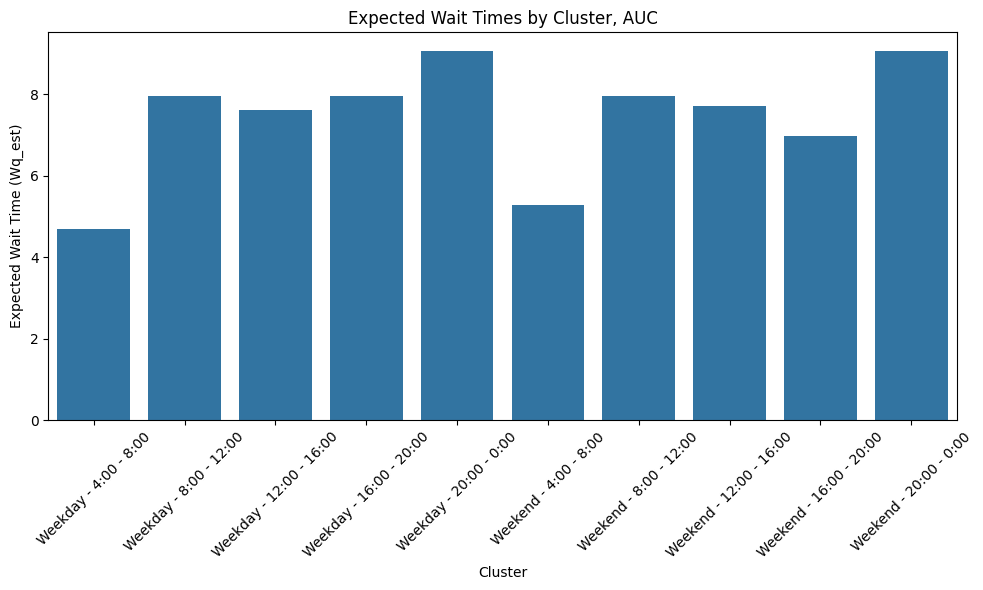

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(x="cluster", y="Wq_est", data=df_auc)
plt.xlabel("Cluster")
plt.ylabel("Expected Wait Time (Wq_est)")
plt.title("Expected Wait Times by Cluster, AUC")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

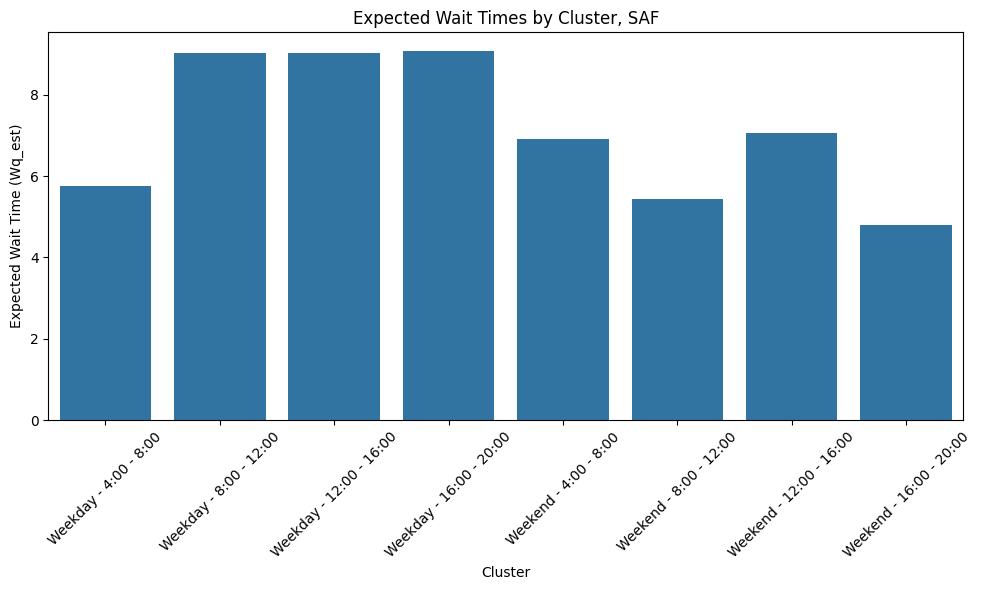

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(x="cluster", y="Wq_est", data=df_saf)
plt.xlabel("Cluster")
plt.ylabel("Expected Wait Time (Wq_est)")
plt.title("Expected Wait Times by Cluster, SAF")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [24]:
df_auc['cluster'] = pd.Categorical(df_auc['cluster'], categories=cluster_ord, ordered=True)
df_saf['cluster'] = pd.Categorical(df_saf['cluster'], categories=cluster_ord, ordered=True)

In [25]:
df_auc_final = df_auc[['cluster','avg_C0_max','arrival_rate','service_rate','traffic_intensity','Wq_est']].drop_duplicates().reset_index(drop=True)
df_saf_final = df_saf[['cluster','avg_C0_max','arrival_rate','service_rate','traffic_intensity','Wq_est']].drop_duplicates().reset_index(drop=True)

In [26]:
df_auc_final

,cluster,avg_C0_max,arrival_rate,service_rate,traffic_intensity,Wq_est
0,Weekday - 4:00 - 8:00,1.906891,0.754365,0.966910,0.780181,4.704890
1,Weekday - 8:00 - 12:00,1.112116,0.833532,0.958982,0.869184,7.971296
2,Weekday - 12:00 - 16:00,1.157624,1.078770,1.210154,0.891432,7.611284
3,Weekday - 16:00 - 20:00,1.114882,0.789286,0.914872,0.862728,7.962640
4,Weekday - 20:00 - 0:00,1.000000,0.075794,0.186043,0.407399,9.070370
5,Weekend - 4:00 - 8:00,1.701394,0.631019,0.820499,0.769067,5.277590
6,Weekend - 8:00 - 12:00,1.114716,0.799074,0.924679,0.864163,7.961443
7,Weekend - 12:00 - 16:00,1.139738,1.166204,1.295952,0.899882,7.707213
8,Weekend - 16:00 - 20:00,1.272095,0.932407,1.075824,0.866691,6.972697
9,Weekend - 20:00 - 0:00,1.000000,0.084259,0.194540,0.433120,9.067731


In [27]:
df_saf_final

,cluster,avg_C0_max,arrival_rate,service_rate,traffic_intensity,Wq_est
0,Weekday - 4:00 - 8:00,1.554245,0.706667,0.880253,0.802799,5.760818
1,Weekday - 8:00 - 12:00,0.995423,0.364167,0.475006,0.766657,9.022093
2,Weekday - 12:00 - 16:00,0.993964,0.414167,0.525035,0.788837,9.019729
3,Weekday - 16:00 - 20:00,0.992982,0.237500,0.347590,0.683275,9.083441
4,Weekend - 4:00 - 8:00,1.292264,0.727083,0.871939,0.833869,6.903412
5,Weekend - 8:00 - 12:00,1.651639,0.508333,0.691878,0.734716,5.448278
6,Weekend - 12:00 - 16:00,1.268482,0.535417,0.676931,0.790947,7.066424
7,Weekend - 16:00 - 20:00,1.872054,0.618750,0.826950,0.748231,4.803075


In [28]:
df_auc_final.to_csv("data-p3/auc_wait_time_preds_by_cluster.csv",index=False)
df_saf_final.to_csv("data-p3/saf_wait_time_preds_by_cluster.csv",index=False)